<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
## ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_NLP_SpamClasiffier


### Spam Classification

[Spamming](https://en.wikipedia.org/wiki/Spamming) is the use of messaging systems to send multiple unsolicited messages (spam) to large numbers of recipients for the purpose of commercial advertising, for the purpose of non-commercial proselytizing, for any prohibited purpose (especially the fraudulent purpose of phishing), or simply sending the same message over and over to the same user. 

Spam Classification: Deciding whether an email is spam or not.



## Imports

In [2]:
# standard libraries
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from jupyterthemes import jtplot as jt

jt.style()

%matplotlib inline
%load_ext lab_black

## Step 1: Load dataset

In [3]:
# path to your (local/cloud) drive
path = os.path.join(os.getcwd(), "spam.csv")

# load dataset
df = pd.read_csv(path, encoding="latin-1")
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# remove useless features
df = df.drop(
    ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis="columns", errors="ignore"
)

In [5]:
# v1 -> is the class label: ham, spam
# ham -> https://en.wiktionary.org/wiki/ham_e-mail
# spam -> https://en.wiktionary.org/wiki/spam#English
# v2 -> is the  email
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Step 2: Pre-processing

In [6]:
# Removing stopwords and stemming
# a stem must be a word
# Example:  fishing, fished, and fisher: stem -> fish
# choose English as the target language
stemmer = SnowballStemmer("english", ignore_stopwords=False)

In [7]:
# Stop words are basically a set of commonly used words in any language
# https://en.wikipedia.org/wiki/Stop_word
# and are filtered out before processing of natural language data
# Example list: https://github.com/igorbrigadir/stopwords/blob/master/en/terrier.txt
nltk.download("stopwords")
stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gamin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# example: remove anything that is not a letter
string_sample = "123This @45is 890-130 an_example !!"
new_string = re.sub("[^a-zA-Z]", " ", string_sample)
print(new_string)

   This    is         an example   


In [9]:
# removing duplicated spaces
" ".join(new_string.split())

'This is an example'

In [10]:
# remove anything that is not a letter in the emails
df["v2_clean"] = [re.sub("[^a-zA-Z]", " ", sms) for sms in df["v2"]]
df.sample(5)

,v1,v2,v2_clean
1488,ham,Tell them no need to investigate about me anyw...,Tell them no need to investigate about me anyw...
4694,spam,URGENT! Your Mobile No 07808726822 was awarded...,URGENT Your Mobile No was awarded...
3265,ham,tap & spile at seven. * Is that pub on gas st ...,tap spile at seven Is that pub on gas st ...
3913,ham,Today is ACCEPT DAY..U Accept me as? Brother S...,Today is ACCEPT DAY U Accept me as Brother S...
1456,ham,U sleeping now.. Or you going to take? Haha.. ...,U sleeping now Or you going to take Haha ...


In [11]:
# list of words in the emails
email_words = [sms.split() for sms in df["v2_clean"]]
print(email_words[:5])

[['Go', 'until', 'jurong', 'point', 'crazy', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'Cine', 'there', 'got', 'amore', 'wat'], ['Ok', 'lar', 'Joking', 'wif', 'u', 'oni'], ['Free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'FA', 'Cup', 'final', 'tkts', 'st', 'May', 'Text', 'FA', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'T', 'C', 's', 'apply', 'over', 's'], ['U', 'dun', 'say', 'so', 'early', 'hor', 'U', 'c', 'already', 'then', 'say'], ['Nah', 'I', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']]


In [12]:
# function to normalize words
def normalize(words):
    normalized_words = list()
    for word in words:
        # remove  the most common words
        if word.lower() not in stop:
            # stemming
            new_word = stemmer.stem(word)
            # lower case
            normalized_words.append(new_word.lower())
    return normalized_words

In [13]:
# normalize words in emails
email_words_norm = [normalize(word) for word in email_words]
print(email_words_norm[:3])

[['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat'], ['ok', 'lar', 'joke', 'wif', 'u', 'oni'], ['free', 'entri', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receiv', 'entri', 'question', 'std', 'txt', 'rate', 'c', 'appli']]


In [14]:
# update dataframe
df["v2_normalized"] = [" ".join(word) for word in email_words_norm]
df.head()

,v1,v2,v2_clean,v2_normalized
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...,nah think goe usf live around though


In [15]:
# training and test datasets
data_register = df["v2_normalized"]
class_label = df["v1"]
factor = 0.2
lucky_number = 7
x_train, x_test, y_train, y_test = train_test_split(
    data_register, class_label, test_size=factor, random_state=lucky_number
)

In [16]:
# train
print(x_train)

4459    wish great day moji told offer alway speechles...
1921                               current food alon also
5255                                       ok sweet dream
5507                               want insid everi night
356     congratul ur award cd voucher gift guarante fr...
                              ...                        
4307                         ha ha pop loo hello ed hello
2550                  pleas sen kind advic pleas come tri
537                     mayb fat finger press button know
1220    nokia tone ur mob everi week txt nok st tone f...
4271                                                  get
Name: v2_normalized, Length: 4457, dtype: object


In [17]:
# test
print(x_test)

83                                              place man
2235    si como listen plaid album quit gd new air hil...
2746                                  k da mani page want
246                                           ask call ok
3120                small problem auction punj ask tiwari
                              ...                        
2460                        cant talk call dont keep call
2661                                        know dad back
2086                                  dude like buff wind
5126    wonder okor great month cherish guy wish well ...
2886                                          k take care
Name: v2_normalized, Length: 1115, dtype: object


In [18]:
# class labels in training
y_train

4459     ham
1921     ham
5255     ham
5507     ham
356     spam
        ... 
4307     ham
2550     ham
537      ham
1220    spam
4271     ham
Name: v1, Length: 4457, dtype: object

In [19]:
# reshape -> gives a new shape to an array without changing its data
# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.reshape.html#numpy.reshape
# -1 -> the unspecified value is inferred
y_train.values.reshape(-1, 1)

array([['ham'],
       ['ham'],
       ['ham'],
       ...,
       ['ham'],
       ['spam'],
       ['ham']], dtype=object)

**Build your custome function**

The real difference between stemming and lemmatization is that stemming reduces word-forms to (pseudo) stems which might be meaningful or meaningless, whereas lemmatization reduces the word-forms to linguistically valid meaning.

In [20]:
# you can build your own NLP function
# edit it according to your requirements
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

nltk.download("punkt")
nltk.download("wordnet")


def NLP_preprocess(some_text):
    """
  Normalization using NLTK and spaCy
  """
    # 1. Tokenization
    NLP_token = word_tokenize(some_text)

    # 2. Stemming
    PS = PorterStemmer()
    NLP_stem = []
    for word in NLP_token:
        NLP_stem.append(PS.stem(word))
    # 3. Lemmatization
    WL = WordNetLemmatizer()
    NLP_lemma = []
    for word in NLP_stem:
        NLP_lemma.append(WL.lemmatize(word))
    # 4. Stopword
    FS = []
    NLP_stop = set(stopwords.words("english"))
    for w in NLP_lemma:
        if w not in NLP_stop:
            FS.append(w)
    # 5. Punctuation
    punctuations = "?:!.,;"
    for word in FS:
        if word in punctuations:
            FS.remove(word)
    # print comparison
    print(" ")
    print(some_text)
    print(FS)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gamin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# example
NLP_preprocess(string_sample)

 
123This @45is 890-130 an_example !!
['123thi', '@', '45i', '890-130', 'an_exampl', '!']


## Step 3: Counts

**Create new features with NLP**

In [22]:
# Convert a collection of text documents to a matrix of token counts
CV = CountVectorizer()

In [23]:
## training
# transforming email into counts
# counting the number of times a word appears in each email
# 'x_train_count' is a sparse matrix, this avoids to store the zeroes
x_train_count = CV.fit_transform(x_train)

# returns: n_samples, n_features
print("total emails =", x_train_count.shape[0])
print("total words =", x_train_count.shape[1])

total emails = 4457
total words = 5595


In [24]:
# show the counts in train
print(x_train_count)

  (0, 5405)	1
  (0, 1991)	2
  (0, 1140)	1
  (0, 3047)	1
  (0, 4944)	1
  (0, 3328)	2
  (0, 162)	1
  (0, 4483)	1
  (0, 1398)	1
  (0, 1921)	1
  (0, 2676)	1
  (0, 458)	1
  (0, 4620)	1
  (0, 1552)	1
  (0, 3214)	1
  (0, 1790)	1
  (0, 2541)	1
  (0, 4984)	1
  (0, 4456)	1
  (1, 1089)	1
  (1, 1734)	1
  (1, 150)	1
  (1, 156)	1
  (2, 3342)	1
  (2, 4701)	1
  :	:
  (4453, 74)	1
  (4454, 2580)	1
  (4454, 1623)	1
  (4454, 2920)	1
  (4454, 1681)	1
  (4454, 3715)	1
  (4454, 683)	1
  (4455, 1529)	1
  (4455, 5150)	2
  (4455, 1776)	1
  (4455, 5065)	1
  (4455, 1885)	1
  (4455, 4786)	1
  (4455, 1792)	1
  (4455, 3249)	1
  (4455, 3960)	1
  (4455, 2160)	1
  (4455, 2341)	1
  (4455, 5327)	1
  (4455, 4533)	1
  (4455, 4956)	3
  (4455, 3032)	1
  (4455, 5067)	1
  (4455, 3248)	1
  (4456, 1885)	1


In [25]:
# full matrix
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
## test
# transforming email into counts
# counting the number of times a word appears in each email
# using the vocabulary fitted with '.fit'
# sparse matrix: only non-zeroes elements are stored
x_test_count = CV.transform(x_test)

# returns: n_samples, n_features
print("total emails =", x_test_count.shape[0])
print("total words =", x_test_count.shape[1])

total emails = 1115
total words = 5595


In [27]:
# array mapping from feature integer indices to feature name
int2feature = CV.get_feature_names()
print(int2feature[:10])

['aa', 'aah', 'aaniy', 'aaooooright', 'aathi', 'ab', 'abbey', 'abeg', 'aberdeen', 'abi']


C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
# warning:
# be aware that running several times next cell
# it will append 'Class' each time
c = 0

In [29]:
# append 'Class' to the end of the list
if c == 0:
    int2feature.append("Class")
    # print last 10 feature names
    print(int2feature[len(int2feature) - 10 : len(int2feature) - 1])
    c = 1
else:
    print("already appended")

['zed', 'zero', 'zf', 'zindgi', 'zoe', 'zogtorius', 'zouk', 'zs', 'zyada']


In [30]:
# new dataset
new_dataset = pd.DataFrame(
    data=np.hstack([x_train_count.toarray(), y_train.values.reshape(-1, 1)]),
    columns=int2feature,
)

In [31]:
# first rows
new_dataset.head()

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abeg,aberdeen,abi,...,zed,zero,zf,zindgi,zoe,zogtorius,zouk,zs,zyada,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam


In [32]:
new_dataset.describe()

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abeg,aberdeen,abi,...,zed,zero,zf,zindgi,zoe,zogtorius,zouk,zs,zyada,Class
count,4457,4457,4457,4457,4457,4457,4457,4457,4457,4457,...,4457,4457,4457,4457,4457,4457,4457,4457,4457,4457
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
freq,4456,4454,4456,4456,4452,4456,4456,4456,4456,4454,...,4452,4456,4456,4456,4455,4456,4456,4456,4456,3855


In [33]:
# write object to a comma-separated values (csv) file
# verify in your folder
new_dataset.to_csv(path[:-4] + "_clean.csv", index=False)

### Data format

In [34]:
# select an email number
row_index = 0
print("non-sparse matrix =", x_train_count[row_index, :].todense())

# original words in the email
print("original words: ", x_train.values[row_index])

# decoded numerical input
DNI = x_train_count[row_index, :].todense()
# inverse_transform: return terms per document with nonzero entries
print("decoded input: ", CV.inverse_transform(DNI))

# index of words
ind = np.where(DNI[0, :] > 0)[1]
print("word indexes: ", ind)

# number of times those words appears in the email
print(x_train_count[row_index, ind].todense())

non-sparse matrix = [[0 0 0 ... 0 0 0]]
original words:  wish great day moji told offer alway speechless offer easili go great length behalf stun exam next friday keep touch sorri
decoded input:  [array(['alway', 'behalf', 'day', 'easili', 'exam', 'friday', 'go',
       'great', 'keep', 'length', 'moji', 'next', 'offer', 'sorri',
       'speechless', 'stun', 'told', 'touch', 'wish'], dtype='<U34')]
word indexes:  [ 162  458 1140 1398 1552 1790 1921 1991 2541 2676 3047 3214 3328 4456
 4483 4620 4944 4984 5405]
[[1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1]]


C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


## Step 4: Learning

Training the classifier and making predictions on the test set

In [35]:
# create a model
MNB = MultinomialNB()

# fit to data
MNB.fit(x_train_count, y_train)

MultinomialNB()

In [36]:
# testing the model

prediction_train = MNB.predict(x_train_count)
print("training prediction\t", prediction_train)

prediction_test = MNB.predict(x_test_count)
print("test prediction\t\t", prediction_test)

training prediction	 ['ham' 'ham' 'ham' ... 'ham' 'spam' 'ham']
test prediction		 ['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


In [37]:
# set_printoptions: If True, always print floating point numbers
# using fixed point notation, in which case numbers equal to zero
# in the current precision will print as zero
np.set_printoptions(suppress=True)

# Ham and Spam probabilities in test
class_prob = MNB.predict_proba(x_test_count)
print(class_prob)

[[0.99224585 0.00775415]
 [0.99710212 0.00289788]
 [0.99977543 0.00022457]
 ...
 [0.99721402 0.00278598]
 [0.99999219 0.00000781]
 [0.99364559 0.00635441]]


In [39]:
# show emails classified as 'spam'
threshold = 0.5
spam_ind = np.where(class_prob[:, 1] > threshold)[0]
print(x_test.values[spam_ind][:10])

['know u u know send chat let find p msg rcvd hg suit land row w j hl ldn year'
 'congrat nokia video camera phone call call cost ppm ave call min vari mobil close post bcm ldn wc n xx'
 'dear dave final notic collect tenerif holiday cash award call landlin tcs sae box cw wx ppm'
 'guarante award mayb even cash claim ur award call free legitimat efreefon number wat u think'
 'free msg get gnarl barkley crazi rington total free repli go messag right'
 'u get phone wanna chat set meet call u cum moro luv jane xx call minmoremobsemspobox po wa'
 'congrat year special cinema pass call c suprman v matrix starwar etc free bx ip pm dont miss'
 'congratul ur award either cd gift voucher free entri week draw txt music tncs www ldew com win ppmx age'
 'hot live fantasi call p per min ntt ltd po box croydon cr wb k'
 'sms ac sptv new jersey devil detroit red wing play ice hockey correct incorrect end repli end sptv']


## Step 5: Accuracy

In [40]:
# accuracy in training set
y_pred_train = prediction_train
print("Train Accuracy: " + str(accuracy_score(y_train, y_pred_train)))

Train Accuracy: 0.9923715503702042


In [41]:
# accuracy in test set (unseen data)
y_true = y_test
y_pred_test = prediction_test
print("Test Accuracy: " + str(accuracy_score(y_true, y_pred_test)))

Test Accuracy: 0.989237668161435


In [42]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_test)
print("Confusion Matrix\n", conf_mat)

Confusion Matrix
 [[965   5]
 [  7 138]]


ipykernel_launcher:11: UserWarning: FixedFormatter should only be used together with FixedLocator
ipykernel_launcher:12: UserWarning: FixedFormatter should only be used together with FixedLocator


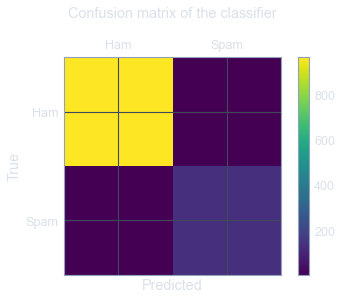

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["Ham", "Spam"]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.title("Confusion matrix of the classifier\n")
fig.colorbar(cax)
ax.set_xticklabels([""] + labels)
ax.set_yticklabels([""] + labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()